# Lab 6

Ganti constant `STATIC` menjadi path ke gambar-gambar yang akan digunakan dan `OUT` menjadi path ke output directory. Contoh jika gambar ada di directory yang sama dengan script ini, maka value nya menjadi `"."`. Library yang dibutuhkan untuk menjalankan script ini adalah sebagai berikut: `scikit-image`, `matplotlib`, `numpy`, `opencv`, dan `ipympl`. Cara menjalankan scriptnya sama seperti menjalankan notebook biasa.

In [1]:
import functools, os, random
from pathlib import Path

SUB = "lab6"
BASE_DIR = Path(os.path.abspath("")).resolve(strict=True).parent
OUT = os.path.join(BASE_DIR, "out", SUB)
STATIC = os.path.join(BASE_DIR, "static", SUB)

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

from skimage import color, feature, io, util

# %matplotlib widget

In [3]:
def help_fig(col, row, titles, images, dpi=100.0):
    fig, axs = plt.subplots(col, row, dpi=dpi)
    if col > 1 or row > 1:
        for i, ax in enumerate(axs.flatten()):
            ax.set_title(titles[i])
            ax.imshow(images[i], cmap="gray")
            ax.set_axis_off()
    else:
        axs.set_title(titles[0])
        axs.imshow(images[0], cmap="gray")
        axs.set_axis_off()
    fig.tight_layout()
    plt.show()

## Classificiation

In [4]:
HISTOGRAM_IMAGE_NAMES = [os.path.join(STATIC, "histogram", filename) for filename in os.listdir(os.path.join(STATIC, "histogram")) if Path(filename).suffix == ".jpg"]

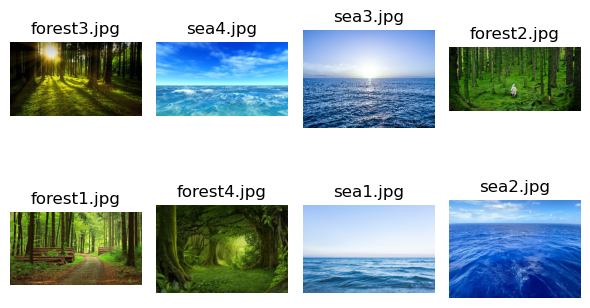

In [5]:
help_fig(2, 4, list(map(lambda filename: Path(filename).name, HISTOGRAM_IMAGE_NAMES)), list(map(lambda filename: io.imread(filename), HISTOGRAM_IMAGE_NAMES)))

### Prediction Method

In [6]:
def forest_or_sea(nama_file):
    image = io.imread(os.path.join(STATIC, nama_file))
    image_g_cum_sum = np.cumsum(np.bincount(image[:, :, 1].flatten()))
    image_b_cum_sum = np.cumsum(np.bincount(image[:, :, 2].flatten()))
    if image_g_cum_sum[-1] - image_g_cum_sum[127] > image_b_cum_sum[-1] - image_b_cum_sum[127]:
        return "hutan"
    else:
        return "lautan"

for image_name in random.sample(HISTOGRAM_IMAGE_NAMES, len(HISTOGRAM_IMAGE_NAMES)):
    print(f"{Path(image_name).name} is a {forest_or_sea(image_name)}")

sea2.jpg is a lautan
forest1.jpg is a hutan
sea3.jpg is a lautan
forest2.jpg is a hutan
forest4.jpg is a hutan
forest3.jpg is a hutan
sea4.jpg is a lautan
sea1.jpg is a lautan


### Reasoning

Fitur yang saya gunakan adalah color channel hijau dan biru karena warna dominan di laut adalah biru dimana hutan adalah hijau. Pertama saya pisah color channel nya, setelah saya hitung lebih banyak warna hijau atau biru di suatu gambar. Jika dominan hijau maka klasifikasi nya adalah hutan, selain itu berarti adalah laut.

## Hough Transformation

In [7]:
TRIANGLE_FILE_NAMES = [os.path.join(STATIC, "segitiga", filename) for filename in os.listdir(os.path.join(STATIC, "segitiga")) if Path(filename).suffix == ".jpg"]

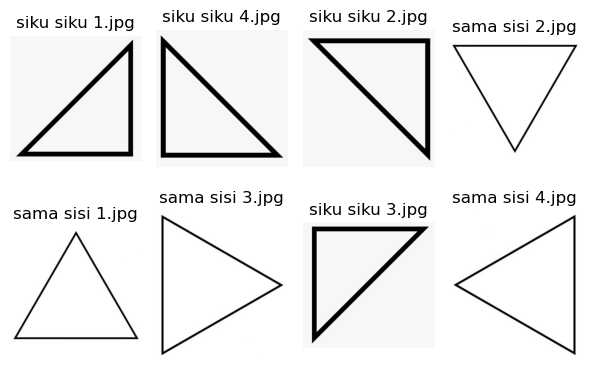

In [8]:
help_fig(2, 4, list(map(lambda filename: Path(filename).name, TRIANGLE_FILE_NAMES)), list(map(lambda filename: io.imread(filename), TRIANGLE_FILE_NAMES)))

### Classifying

In [9]:
def right_or_equilateral(file_name):
    image_raw = io.imread(file_name)
    if len(image_raw[0][0]) == 3:
        image = util.img_as_ubyte(color.rgb2gray(image_raw))
    else:
        image = util.img_as_ubyte(color.rgb2gray(color.rgba2rgb(image_raw)))
    image_raw_lines = cv2.HoughLines(cv2.Canny(image, 50, 150, 3), 1, np.pi / 180, 200)
    
    # Remove similar lines
    # idea from https://newbedev.com/choosing-lines-from-hough-lines
    # implemented by Ilman
    image_strong_lines = []
    for line in image_raw_lines:
        for rho, theta in line:
            if len(image_strong_lines) == 0:
                image_strong_lines.append([rho, theta])
            else:
                similar = False
                for strong_line_rho, strong_line_theta in image_strong_lines:
                    if abs(rho - strong_line_rho) < 50 and abs(theta - strong_line_theta) * 1000 < 100:
                        similar = True
                        break
                if not similar:
                    image_strong_lines.append([rho, theta])
        if len(image_strong_lines) >= 3:
            break
    vertical_horizontal_line_count = 0
    for rho, theta in image_strong_lines:
        if theta == 0.0 or np.isclose(1.5707964, theta):
            vertical_horizontal_line_count += 1
    if vertical_horizontal_line_count == 2:
        return "equilateral"
    else:
        return "right"

for file_name in random.sample(TRIANGLE_FILE_NAMES, len(TRIANGLE_FILE_NAMES)):
    print(f"{Path(file_name).name} is a(n) {right_or_equilateral(file_name)} triangle")

siku siku 3.jpg is a(n) equilateral triangle
siku siku 2.jpg is a(n) equilateral triangle
sama sisi 2.jpg is a(n) right triangle
sama sisi 4.jpg is a(n) right triangle
sama sisi 1.jpg is a(n) right triangle
sama sisi 3.jpg is a(n) right triangle
siku siku 4.jpg is a(n) equilateral triangle
siku siku 1.jpg is a(n) equilateral triangle


### Reasoning

Parameter yang di gunakan untuk menentukan tipe segitiga nya dalah menggunakan `theta`. Di soal, tertera bahwa bentuk dan orientasi segi tiganya hanya yang seperti di dataset saja. Pattern yang saya temukan adalah semua segi tiga siku-siku pasti memiliki dua sisi yang horizontal atau vertical. Nilai `theta` dari garis  yang horizontal `0` dan vertical sekitar `1.57...`. Dari informasi diatas, kita bisa decide jika ada garis yang horizontal **dan** vertical, segi tiga tersebut adalah segi tiga siku-siku.

Sebagai tambahan, saya melakukan filtering garis yang mirip, karena hasil hough transform nya menghasilkan garis yang duplikat. TL;DR nya saya compare line nya, jika ada yang mirip dengan threshold sekian, maka garis tersebut tidak akan saya pakai.

## Template Matching

In [10]:
match1 = io.imread(os.path.join(STATIC, "template matching", "pertandingan 1.jpeg"))
match2 = io.imread(os.path.join(STATIC, "template matching", "pertandingan 2.jpeg"))
ball = io.imread(os.path.join(STATIC, "template matching", "bola.jpg"))
match1_gray = color.rgb2gray(match1)
match2_gray = color.rgb2gray(match2)
ball_gray = color.rgb2gray(ball)

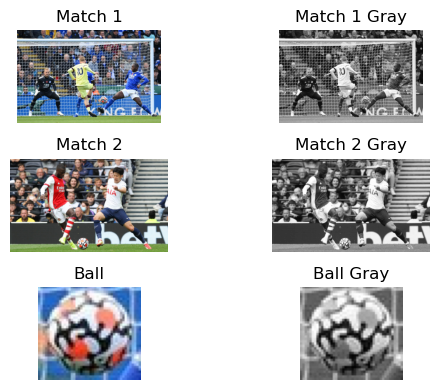

In [11]:
help_fig(3, 2, ["Match 1", "Match 1 Gray", "Match 2", "Match 2 Gray", "Ball", "Ball Gray"], [match1, match1_gray, match2, match2_gray, ball, ball_gray])

### Exploration

In [12]:
match1_match = feature.match_template(match1_gray, ball_gray)
match2_match = feature.match_template(match2_gray, ball_gray)

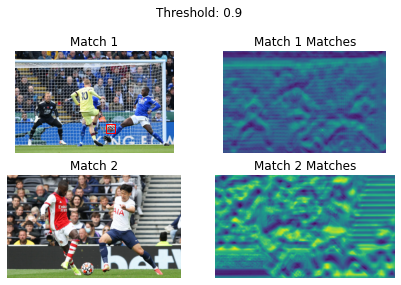

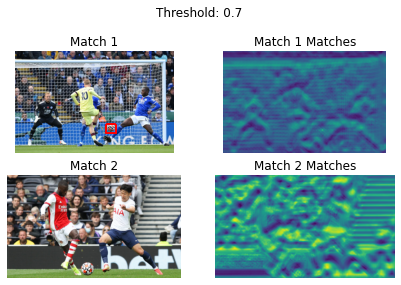

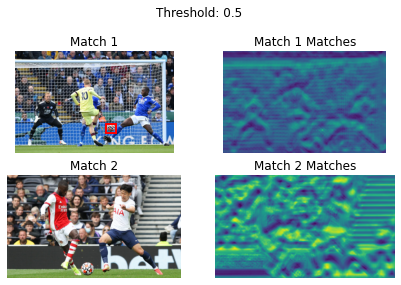

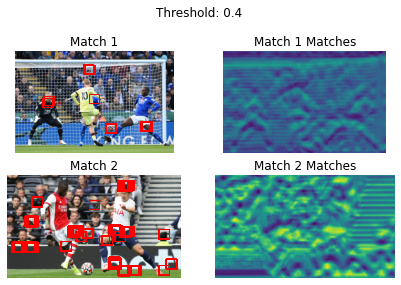

In [13]:
def fig_match(threshold):
    ball_height, ball_width = ball_gray.shape
    fig, ((match1_plot, match1_matches_plot), (match2_plot, match2_matches_plot)) = plt.subplots(2, 2)

    match1_plot.set_title("Match 1")
    match1_plot.imshow(match1)
    match1_plot.set_axis_off()
    match1_match_thresholded = np.where(match1_match >= threshold)
    for point in zip(*match1_match_thresholded[:: -1]):
        match1_rect = plt.Rectangle(point, ball_width, ball_height, edgecolor='r', facecolor='none')
        match1_plot.add_patch(match1_rect)

    match1_matches_plot.set_title("Match 1 Matches")
    match1_matches_plot.imshow(match1_match)
    match1_matches_plot.set_axis_off()
    match1_matches_plot.autoscale(False)

    match2_plot.set_title("Match 2")
    match2_plot.imshow(match2)
    match2_plot.set_axis_off()
    match2_match_thresholded = np.where(match2_match >= threshold)
    for point in zip(*match2_match_thresholded[:: -1]):
        match2_rect = plt.Rectangle(point, ball_width, ball_height, edgecolor='r', facecolor='none')
        match2_plot.add_patch(match2_rect)

    match2_matches_plot.set_title("Match 2 Matches")
    match2_matches_plot.imshow(match2_match)
    match2_matches_plot.set_axis_off()
    match2_matches_plot.autoscale(False)

    fig.suptitle(f"Threshold: {threshold}")
    fig.tight_layout()
    fig.show()

MATCHING_THRESHOLD = [0.9, 0.7, 0.5, 0.4]

for threshold in MATCHING_THRESHOLD:
    fig_match(threshold)

### Differences

Perbedaan hasil matching terjadi saat nilai `threshold` nya dibawah `0.5` dimana yang sebelumnya hanya ada satu match di pertandingan satu, menjadi sangat banyak match di kedua gambar pertandingan. Hal ini terjadi karena hasil matching nya sangat buruk. Satu-satunya matching yang terjadi diatas `0.5` terjadi pada pertandingan 1 karena template nya diambil dari gambar tersebut. Value matching di area asli mencapai `0.9999...`, sedangkat nilai maximum lainnya dibawah `0.5` semua.

### Pros/Cons

Kelebihan dari teknik ekstraksi fitur template matching adalah bisa mendapatkan match jika template nya berdasarkan gambar asli dan tidak terdapat distorsi di template nya. Kekurangannya adalah jika terjadi perubahan, walaupun terlihat jelas oleh manusia, template matching akan gagal mendapatkan match yang bahkan tidak terlalu bagus. Menurut pengertian saya, template matching bagus digunakan ke gambar yang memiliki background yang sama dan orientasi object di template nya akan selalu sama. Maka dari itu, template matching tidak baik digunakan di gambar pertandingan bola yang disediakan karena pertama background di belakan bola nya akan sering berubah, dan kedua karena bola nya sendiri akan berputar-putar yang terus menyulitkan matching nya.